In [1]:
import os
import sys
import gzip
import json
import joblib
import hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
import sklearn
from sklearn import metrics
import lightgbm as lgb

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from IPython.display import SVG
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True # Change output to SVG format
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500

In [2]:
import matplotlib.pyplot as plt

# config
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'font.size': 16})

# Change Matplotlib font to Helvetica
import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['font.family'] = 'Helvetica'
fm.findfont("Helvetica", fontext="ttx", rebuild_if_missing=False)

'/System/Library/Fonts/Helvetica.ttc'

In [3]:
class HorizontalDisplay():
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(arg) for arg in self.args)

In [4]:
def roundDownToMultiple(number, multiple):
    num = number
    return num - (num % multiple)

def roundUpToMultiple(number, multiple):
    num = number + (multiple - 1)
    return num - (num % multiple)

In [5]:
base_dir = os.path.dirname(os.path.realpath('__file__')).replace('/scripts/MLtest', '')
base_dir

'/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML'

# Data loader

In [6]:
df = pd.read_csv(os.path.join(base_dir, 'data/QMdata4ML/df_elec_x.csv.gz'), index_col=0)
print(df.shape[0])
print(df.smiles.nunique())
df.head(2)

534119
47440


,smiles,elec_sites,elec_names,MAA_values,elec_GCS_3_cm5,Set,elec_SMI2GCS_3_cm5,elec_SMI2GCS_5_cm5,elec_RDKitCountFP_512,elec_RDKitGasteigerGCS_5,elec_AtomNumGCS_5
0,NOCc1cccc(I)c1,3,double_bond,90.348433,"[-0.01706, 0.12057, -0.11146, -0.08969, 0.0, -...",Train_fold5,"[-0.00668, 0.12661, -0.09866, -0.09247, 0.0, -...","[-0.00668, 0.12661, -0.09866, -0.09247, 0.0, -...","[4, 0, 4, 5, 2, 3, 0, 4, 3, 6, 0, 6, 4, 1, 0, ...","[-0.01928812973227673, 0.0929936027236162, -0....","[6, 6, 6, 6, 0.0, 8, 1, 1, 6, 1, 0.0, 6, 1, 0...."
1,NOCc1cccc(I)c1,4,double_bond,94.924314,"[-0.08969, -0.01706, -0.08484, 0.09939, 0.0, 0...",Train_fold2,"[-0.09247, -0.00668, -0.07901, 0.0887, 0.0, 0....","[-0.09247, -0.00668, -0.07901, 0.0887, 0.0, 0....","[4, 0, 4, 7, 0, 1, 0, 4, 1, 6, 0, 4, 4, 1, 0, ...","[-0.056572952259338685, -0.01928812973227673, ...","[6, 6, 6, 1, 0.0, 6, 6, 0.0, 6, 1, 0.0, 0.0, 0..."


# Validation set

In [7]:
### REGRESSOR SETUP ###
### Load final model ###
lgb_model_path = os.path.join(base_dir, 'src/esnuelML/models/elec/SMI2GCS_3_cm5_model.txt.gz')
with gzip.open(lgb_model_path, mode="rt") as file:
    lgb_model_str = file.read()
final_model = lgb.Booster(model_str=lgb_model_str)


### REGRESSOR SETUP ###
atom_descriptor = 'elec_SMI2GCS_3_cm5'
target_type = 'MAA_values'
num_cpu = 1 # <---- CHANGE NUMBER OF CPUs HERE !!!
os.environ['MKL_NUM_THREADS'] = str(num_cpu)
os.environ['MKL_DOMAIN_NUM_THREADS'] = 'MKL_BLAS='+str(num_cpu)
os.environ["OMP_NUM_THREADS"] = '1'

print(f'----------------REGRESSOR SETUP----------------')
print(f'Atom Descriptor:      {atom_descriptor}')
print(f'Target type           {target_type}')
print(f'Number of CPUs:       {num_cpu}')
print('\n')
### END ###

### Training/test data split ###
df[atom_descriptor] = df.apply(lambda row: np.array(json.loads(row[atom_descriptor])), axis=1) # turn str list into real list
df[target_type] = df.apply(lambda row: float(row[target_type]), axis=1) # turn str list into real list

df_train = df[df['Set'].str.contains('Train')]
df_test = df[df['Set'] == 'Test']

X_test = np.asarray(df_test[atom_descriptor].tolist())
Y_test = np.asarray(df_test[target_type].tolist())

print('----------------DATA SET----------------')
print(f'Training size:           {df_train.shape[0]} ({df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]):.2f})')
print(f'Held-out test size:      {df_test.shape[0]}  ({df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]):.2f})')
print('\n')
### END ###

Finished loading model, total used 322 iterations
----------------REGRESSOR SETUP----------------
Atom Descriptor:      elec_SMI2GCS_3_cm5
Target type           MAA_values
Number of CPUs:       1


----------------DATA SET----------------
Training size:           454001 (0.85)
Held-out test size:      80118  (0.15)




In [8]:
MSE_list = []
RMSE_list = []
MAE_list = []
R2_list = []
nfolds = 5
for i in range(1,nfolds+1):
    
    train = df_train[df_train['Set'] != f'Train_fold{i}']
    train_x = np.asarray(train[atom_descriptor].tolist())
    train_y = np.asarray(train[target_type].tolist())
    
    vaild = df_train[df_train['Set'] == f'Train_fold{i}']
    valid_x = np.asarray(vaild[atom_descriptor].tolist())
    valid_y = np.asarray(vaild[target_type].tolist())

    valid_y_preds = final_model.predict(valid_x, num_iteration=final_model.best_iteration)
    MSE_list.append(metrics.mean_squared_error(valid_y, valid_y_preds))
    RMSE_list.append(metrics.mean_squared_error(valid_y, valid_y_preds, squared=False))
    MAE_list.append(metrics.mean_absolute_error(valid_y, valid_y_preds))
    R2_list.append(metrics.r2_score(valid_y, valid_y_preds))

In [9]:
print(RMSE_list)

[22.142989718743717, 6.408626988412538, 6.392539805825183, 6.3822696129405365, 6.421925411755966]


In [10]:
# By comparing the above results to the output, it is found that the model is trained on the last CV round
i = 0
print(f'Pred. MSE (validation): {MSE_list[i]:.4f}')
print(f'Pred. RMSE (validation): {RMSE_list[i]:.4f}')
print(f'Pred. MAE (validation): {MAE_list[i]:.4f}')
print(f'Pred. R2 (validation): {R2_list[i]:.4f}')

Pred. MSE (validation): 490.3120
Pred. RMSE (validation): 22.1430
Pred. MAE (validation): 15.2890
Pred. R2 (validation): 0.9052


<Figure size 800x800 with 0 Axes>

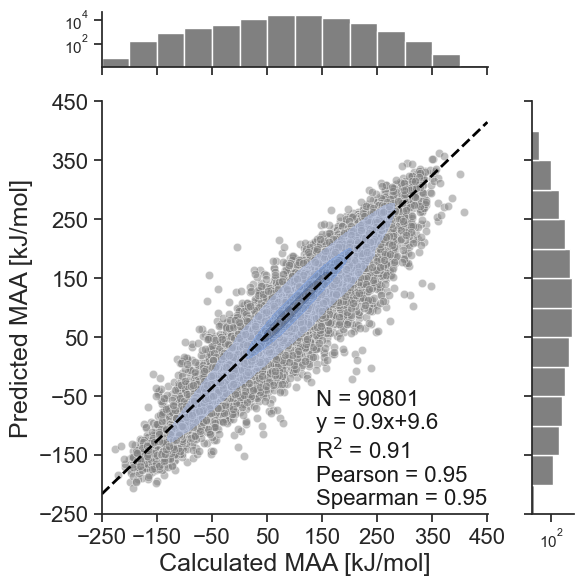

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

fig = plt.figure(figsize=(8, 8))
# sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')

vaild = df_train[df_train['Set'] == f'Train_fold{i+1}']
valid_x = np.asarray(vaild[atom_descriptor].tolist())
valid_y = np.asarray(vaild[target_type].tolist())
valid_y_preds = final_model.predict(valid_x, num_iteration=final_model.best_iteration)

x = valid_y
y = valid_y_preds

xmin = min(x) - (max(x) - min(x)) * 0.05
xmax = max(x) + (max(x) - min(x)) * 0.05
ymin = min(y) - (max(y) - min(y)) * 0.05
ymax = max(y) + (max(y) - min(y)) * 0.05

data = np.column_stack((x,y))
df_plot = pd.DataFrame(data, columns=["x", "y"])

g = sns.JointGrid(x="x", y="y", data=df_plot, marginal_ticks=True)
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="Grey")
b = g.plot_joint(sns.scatterplot, alpha=0.5, color="Grey", linewidth=.5, rasterized=True)
b = g.plot_joint(sns.kdeplot, levels=4, fill=True, alpha=0.6, cut=1)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
else:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.show()

## Test set

In [12]:
y_true = Y_test
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
MSE_val = metrics.mean_squared_error(y_true, y_pred)
RMSE_val = metrics.mean_squared_error(y_true, y_pred, squared=False)
MAE_val = metrics.mean_absolute_error(y_true, y_pred)
R2_val = metrics.r2_score(y_true, y_pred)

print(f'Pred. MSE: {MSE_val:.4f}')
print(f'Pred. RMSE: {RMSE_val:.4f}')
print(f'Pred. MAE: {MAE_val:.4f}')
print(f'Pred. R2: {R2_val:.4f}')

Pred. MSE: 487.4929
Pred. RMSE: 22.0792
Pred. MAE: 15.3234
Pred. R2: 0.9055


In [13]:
print(len(np.where(abs(y_pred - y_true) >= 100)[0]), 'out of', len(y_true))
print(f'{(len(np.where(abs(y_pred - y_true) >= 100)[0]) / len(y_true)) * 100:.2f} %')

241 out of 80118
0.30 %


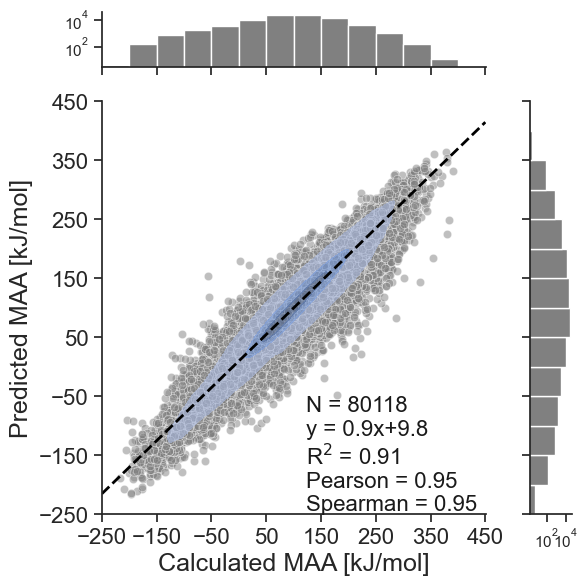

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats


# fig = plt.subplots(figsize=(6, 6))

# sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')

x = y_true
y = y_pred

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

data = np.column_stack((x,y))
df_plot = pd.DataFrame(data, columns=["x", "y"])

g = sns.JointGrid(x="x", y="y", data=df_plot, marginal_ticks=True)
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="Grey")
b = g.plot_joint(sns.scatterplot, alpha=0.5, color="Grey", linewidth=.5, rasterized=True)
# b = g.plot_joint(sns.scatterplot, alpha=0.05, color="Grey", linewidth=.5, rasterized=True, edgecolor=None)
b = g.plot_joint(sns.kdeplot, levels=4, fill=True, alpha=0.6, cut=1)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
else:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.savefig('figures/MAAtest.pdf')
plt.show()

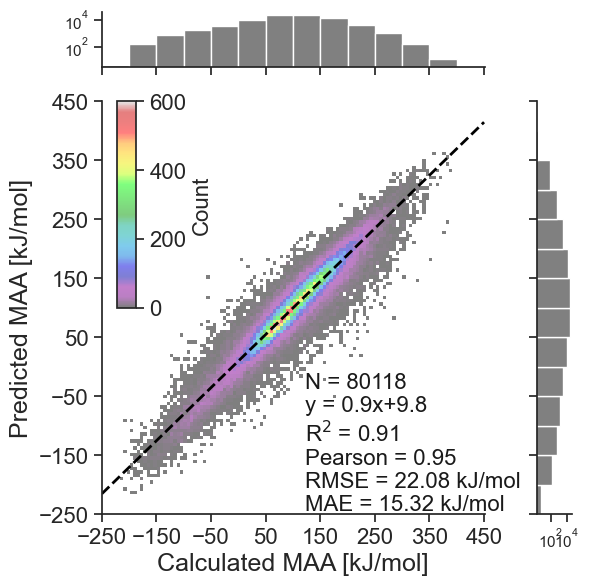

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats


# fig = plt.subplots(figsize=(6, 6))

# sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')

x = y_true
y = y_pred

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

data = np.column_stack((x,y))
df_plot = pd.DataFrame(data, columns=["x", "y"])

g = sns.JointGrid(x="x", y="y", data=df_plot, marginal_ticks=True)
g.figure.set_size_inches((6, 6))
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="Grey")

h = g.plot_joint(sns.histplot, bins=(100, 100), alpha=0.5, cmap=plt.cm.nipy_spectral, cbar=False)
cbar = plt.colorbar(h.ax_joint.collections[0], cax=g.ax_joint.inset_axes((0.04, 0.5, 0.05, 0.5)), orientation='vertical')
cbar.set_label('Count', fontsize=16)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_yticks(np.arange(0,601,100))
h.ax_joint.collections[0].set_clim(vmin=0, vmax=600)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    # g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nRMSE = {metrics.mean_squared_error(x, y, squared=False):.2f} kJ/mol \nMAE = {metrics.mean_absolute_error(x, y):.2f} kJ/mol", color='k', fontsize=16)
else:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    # g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nRMSE = {metrics.mean_squared_error(x, y, squared=False):.2f} kJ/mol \nMAE = {metrics.mean_absolute_error(x, y):.2f} kJ/mol", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.savefig('figures/MAAtest_cutoffNone.pdf')
plt.show()

In [18]:
data = np.column_stack((y_true,y_pred))
df_plot = pd.DataFrame(data, columns=["x", "y"])
df_plot['error'] = df_plot['y'] - df_plot['x']
df_plot['abs_error'] = abs(df_plot['error'])

In [19]:
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
model_RF = load(os.path.join(base_dir, 'src/esnuelML/models/elec/RF_SMI2GCS_3_cm5.joblib'))

tree_predictions = []
for tree in tqdm(model_RF.estimators_):
    tree_predictions.append(tree.predict(X_test))

df_plot['RF_DT_std'] = np.std(tree_predictions, axis=0)

100%|██████████| 200/200 [00:09<00:00, 20.10it/s]


In [20]:
df_plot['Estimated Error'] = 0.6140308723543682 * df_plot['RF_DT_std'] + 4.3372205727670305

cutoff = df_plot.sort_values(by='Estimated Error').iloc[df_plot.shape[0]-int(df_plot.shape[0]*0.1)]['Estimated Error']
print('Cutoff:', cutoff)
cutoff = roundDownToMultiple(cutoff, 5)
print('Cutoff:', cutoff)

df_plot['Outlier'] = df_plot['Estimated Error'].apply(lambda e: 'Yes' if e > cutoff else 'No')
print(f"Data above cutoff: {df_plot[df_plot['Estimated Error'] > cutoff].shape[0] / df_plot.shape[0] * 100:.2f} %")

df_plot["abs_z"] = df_plot.abs_error/df_plot['RF_DT_std']

df_plot.head(2)

Cutoff: 31.378113695654502
Cutoff: 30.0
Data above cutoff: 12.29 %


,x,y,error,abs_error,RF_DT_std,Estimated Error,Outlier,abs_z
0,227.719619,245.100638,17.381019,17.381019,10.905076,11.033274,No,1.593847
1,37.868317,12.719186,-25.149131,25.149131,37.554496,27.396841,No,0.669670


In [21]:
print(f"Data above 30 kJ/mol: {df_plot[df_plot['Estimated Error'] > 30].shape[0] / df_plot.shape[0] * 100:.2f} %")
print(f"Data above 25 kJ/mol: {df_plot[df_plot['Estimated Error'] > 25].shape[0] / df_plot.shape[0] * 100:.2f} %")
print(f"Data above 20 kJ/mol: {df_plot[df_plot['Estimated Error'] > 20].shape[0] / df_plot.shape[0] * 100:.2f} %")

Data above 30 kJ/mol: 12.29 %
Data above 25 kJ/mol: 25.00 %
Data above 20 kJ/mol: 45.77 %


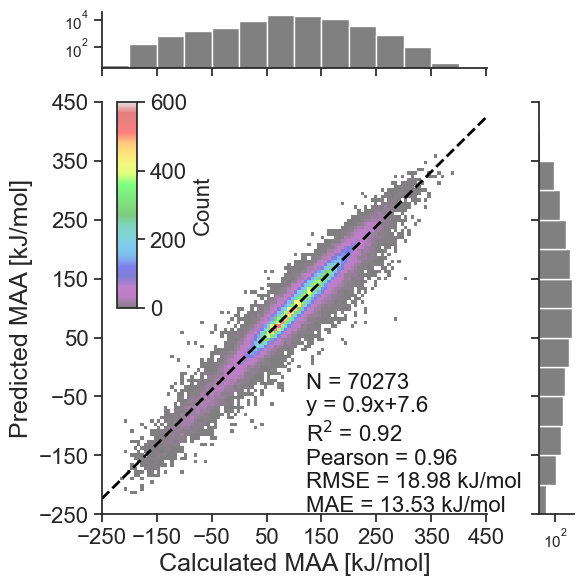

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats


# fig = plt.subplots(figsize=(6, 6))

# sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')

x = df_plot[df_plot['Estimated Error'] <= 30]['x']
y = df_plot[df_plot['Estimated Error'] <= 30]['y']
# x = df_plot[df_plot['Estimated Error'] <= 25]['x']
# y = df_plot[df_plot['Estimated Error'] <= 25]['y']
# x = df_plot[df_plot['Estimated Error'] <= 20]['x']
# y = df_plot[df_plot['Estimated Error'] <= 20]['y']

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

g = sns.JointGrid(x="x", y="y", data=pd.DataFrame(np.column_stack((x,y)), columns=["x", "y"]), marginal_ticks=True)
g.figure.set_size_inches((6, 6))
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="Grey")

h = g.plot_joint(sns.histplot, bins=(100, 100), alpha=0.5, cmap=plt.cm.nipy_spectral, cbar=False)
cbar = plt.colorbar(h.ax_joint.collections[0], cax=g.ax_joint.inset_axes((0.04, 0.5, 0.05, 0.5)), orientation='vertical')
cbar.set_label('Count', fontsize=16)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_yticks(np.arange(0,601,100))
h.ax_joint.collections[0].set_clim(vmin=0, vmax=600)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    # g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nRMSE = {metrics.mean_squared_error(x, y, squared=False):.2f} kJ/mol \nMAE = {metrics.mean_absolute_error(x, y):.2f} kJ/mol", color='k', fontsize=16)
else:
    # g.ax_joint.text(xmax-650, ymin+500, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)
    # g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
    g.ax_joint.text(xmax-300, ymin, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nRMSE = {metrics.mean_squared_error(x, y, squared=False):.2f} kJ/mol \nMAE = {metrics.mean_absolute_error(x, y):.2f} kJ/mol", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.savefig('figures/MAAtest_cutoff30.pdf')
plt.show()

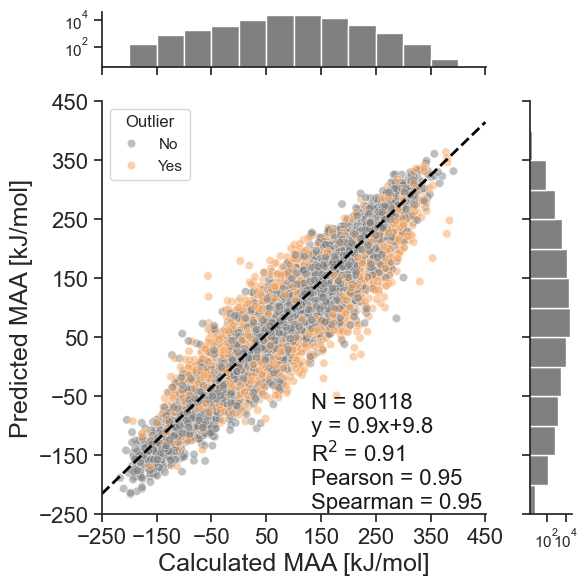

In [28]:
sns.set_theme(style='ticks')

x = df_plot['x']
y = df_plot['y']

g = sns.JointGrid(x="x", y="y", data=df_plot, marginal_ticks=True, hue='Outlier')
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="Grey")
b = g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=.5, palette=["Grey", "sandybrown"], rasterized=True)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    g.ax_joint.text(xmax-290, ymin+5, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
else:
    g.ax_joint.text(xmax-290, ymin+5, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.savefig('figures/MAAtest_colorcoding.pdf')
plt.show()

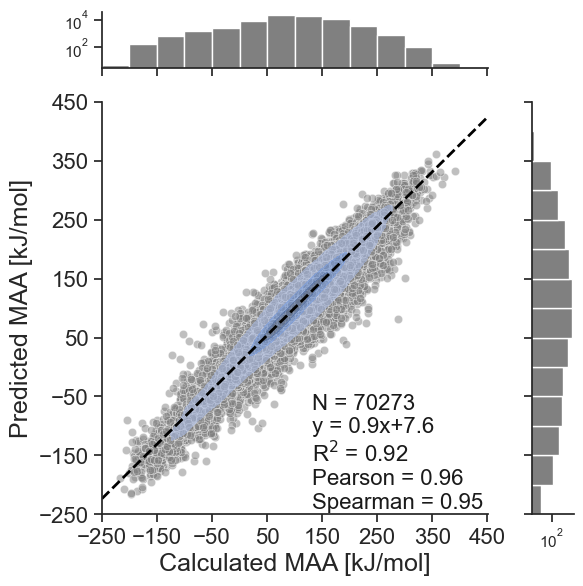

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

sns.set_theme(style='ticks')

x = df_plot[df_plot['Outlier'] == "No"]['x']
y = df_plot[df_plot['Outlier'] == "No"]['y']

g = sns.JointGrid(x="x", y="y", data=df_plot[df_plot['Outlier'] == "No"], marginal_ticks=True)
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="Grey")
b = g.plot_joint(sns.scatterplot, alpha=0.5, color="Grey", linewidth=.5, rasterized=True)
b = g.plot_joint(sns.kdeplot, levels=4, fill=True, alpha=0.6, cut=1)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    g.ax_joint.text(xmax-290, ymin+5, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
else:
    g.ax_joint.text(xmax-290, ymin+5, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.savefig('figures/MAAtest_noOutliers.pdf')
plt.show()

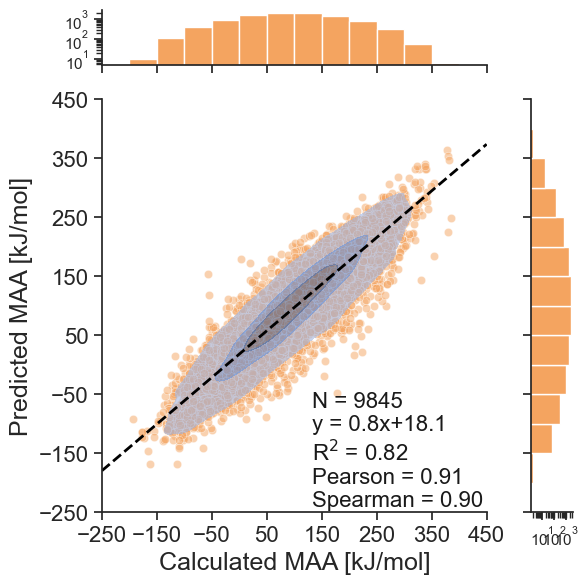

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

sns.set_theme(style='ticks')

x = df_plot[df_plot['Outlier'] == "Yes"]['x']
y = df_plot[df_plot['Outlier'] == "Yes"]['y']

g = sns.JointGrid(x="x", y="y", data=df_plot[df_plot['Outlier'] == "Yes"], marginal_ticks=True)
g.ax_marg_x.hist(x, bins=np.arange(-250, 451, 50), log=True, color="sandybrown")
g.ax_marg_y.hist(y, bins=np.arange(-250, 451, 50), orientation="horizontal", log=True, color="sandybrown")
b = g.plot_joint(sns.scatterplot, alpha=0.5, color="sandybrown", linewidth=.5, rasterized=True)
b = g.plot_joint(sns.kdeplot, levels=4, fill=True, alpha=0.6, cut=1)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))
g.ax_joint.plot(np.arange(-250,451,50), slope * np.arange(-250,451,50) + intercept, 'Black', linestyle='dashed', lw=2)
if intercept > 0:
    g.ax_joint.text(xmax-290, ymin+5, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)
else:
    g.ax_joint.text(xmax-290, ymin+5, f"N = {len(x)} \ny = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).correlation:.2f}", color='k', fontsize=16)

g.ax_joint.set_xlabel('Calculated MAA [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Predicted MAA [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)
g.ax_joint.set_xticks(np.arange(-250,451,100))
g.ax_joint.set_yticks(np.arange(-250,451,100))
g.ax_joint.set_xlim(-250,451)
g.ax_joint.set_ylim(-250,450)

plt.tight_layout()
plt.savefig('figures/MAAtest_Outliers.pdf')
plt.show()

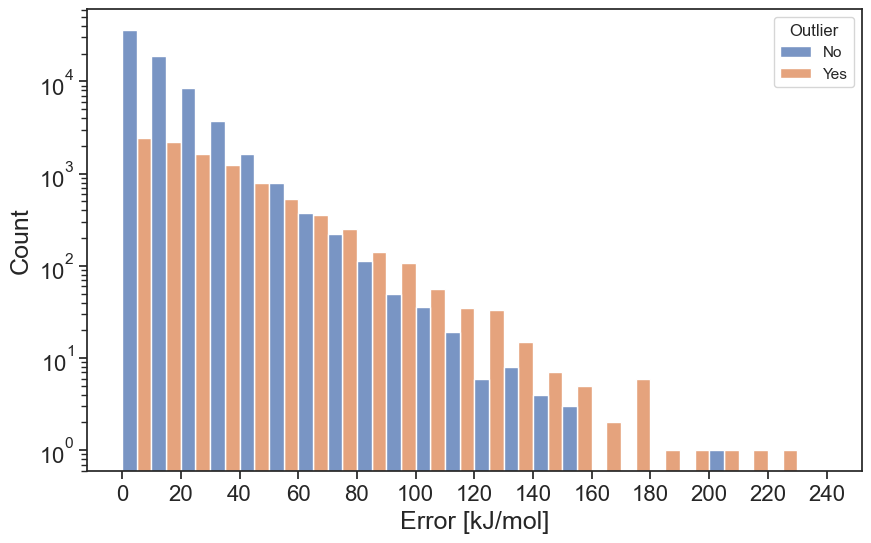

In [20]:
sns.histplot(data=df_plot, x="abs_error", bins=np.arange(0, 250, 10), hue='Outlier', element="bars", multiple='dodge')
plt.yscale('log')

plt.xlabel('Error [kJ/mol]', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.xticks(np.arange(0,251,20))
plt.show()

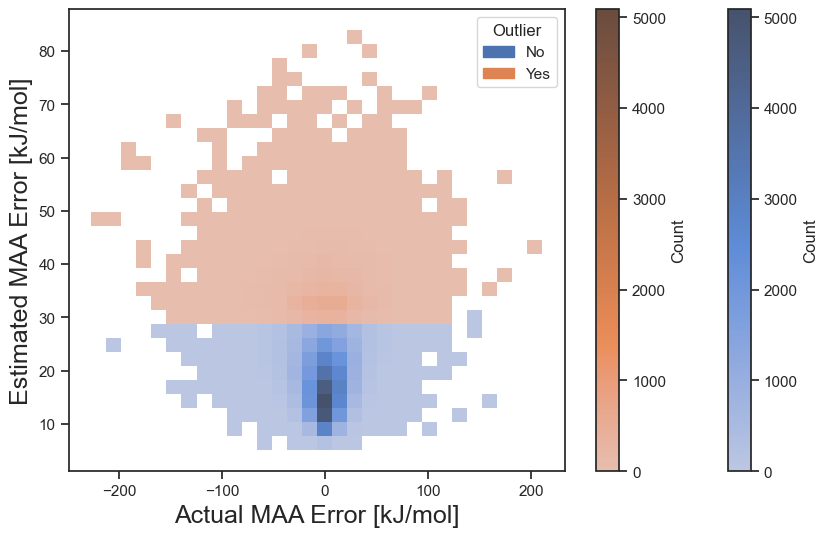

In [21]:
sns.histplot(df_plot, x="error", y="Estimated Error",
             bins=30, discrete=(False, False), log_scale=(False, False),
             cbar=True, cbar_kws=dict(shrink=1, label='Count'), hue='Outlier')
plt.xlabel('Actual MAA Error [kJ/mol]', fontsize=18)
plt.ylabel('Estimated MAA Error [kJ/mol]', fontsize=18)
plt.show()

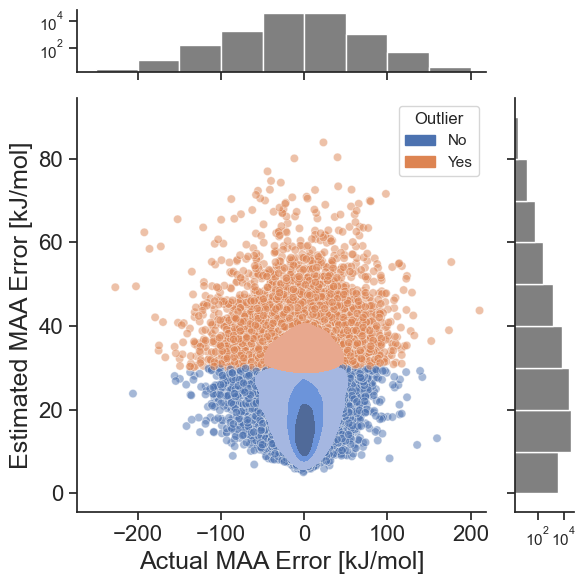

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

sns.set_theme(style='ticks')

x = df_plot['error']
y = df_plot['Estimated Error']

g = sns.JointGrid(x="error", y="Estimated Error", data=df_plot, marginal_ticks=True, hue='Outlier')
g.ax_marg_x.hist(x, bins=np.arange(-250, 250, 50), log=True, color="Grey")
g.ax_marg_y.hist(y, bins=np.arange(0, 100, 10), orientation="horizontal", log=True, color="Grey")
b = g.plot_joint(sns.scatterplot, alpha=0.5, color="Grey", linewidth=.5, rasterized=True)
b = g.plot_joint(sns.kdeplot, levels=4, fill=True, alpha=1, cut=1)

g.ax_joint.set_xlabel('Actual MAA Error [kJ/mol]', fontsize=18)
g.ax_joint.set_ylabel('Estimated MAA Error [kJ/mol]', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()